<a href="https://colab.research.google.com/github/MartinBelderBMC/RPO_Dashboard/blob/dev_branch/Frontend_RPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **RPO Dashboard**

Dit dashboard stelt je in staat om je eigen selecties uit de RPO data samen te stellen. Je kunt de resultaten vervolgens exporteren

Druk op Ctrl-F9 om de applicatie te draaien. Daarna kan je je eigen overzicht samenstellen.

De applicatie opent een dialoogvenster om toestemming te vragen voor toegang te vragen.

NB: maak vooraf een shortcut aan in 'My Drive' naar de map 'RPO applicatie'





In [567]:
#@title
import pandas as pd
import numpy as np
import geopandas as gpd

import io, os, itertools

import matplotlib.pyplot as plt

from ipywidgets import widgets, interact, interact_manual, Layout

from IPython.display import display, update_display, clear_output

from google.colab import drive

from openpyxl.drawing.image import Image

from functools import reduce
from itertools import product

In [568]:
#@title
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [569]:
#@title
#werkmap = "/content/gdrive/Shareddrives/BMC Data en Dienstverlening/RPO Dashboard/"

bewerkte_data_map = os.path.join("/content/gdrive/My Drive/RPO applicatie", "data", "2023")

geo_data_map = os.path.join(bewerkte_data_map,'geo')

out_results_save_map = "/content/gdrive/My Drive/"

In [570]:
primary_colors = ["#B4A38A", "#F7F5F0", "#0F1941"]

In [571]:
#@title
base_file_voorz = pd.read_csv(os.path.join(bewerkte_data_map, "voorzieningen_tabel.csv"),
                              sep = ';',
                              dtype = object)

In [572]:
# @title
data =  {'Prognose':
            pd.read_csv(os.path.join(bewerkte_data_map, 'prognosedata.csv'),
                        sep = ';',
                        encoding="utf-8",
                        dtype = {'BRIN (vestiging)' : object,
                                 'Gemeentenummer (instelling)' : object,
                                 'Jaar' : int,
                                 'Onderwijssoort' : object,
                                 'Aantal' : float}
                        ),
         'Aantallen per woonplaats' :
            pd.read_csv(os.path.join(bewerkte_data_map, 'leerlingdata_woonp.csv'),
                        sep = ';',
                         dtype = {'BRIN (instelling)' : object,
                                  'BRIN (vestiging)' : object,
                                  'Gemeentenummer (instelling)' : object,
                                  'Gemeentenummer (leerling)' : object,
                                  'Aantal' : int,
                                  'Jaar' : int,
                                  'Woonachtig binnen gemeente instelling' : bool}),
         'Aantallen per onderwijssoort' :
            pd.read_csv(os.path.join(bewerkte_data_map, 'leerlingdata_onderwijssoort.csv'),
                        sep = ';',
                        dtype = {'BRIN (instelling)' : object,
                                 'BRIN (vestiging)' : object,
                                 'Soort onderwijs' : object,
                                 'Elementcode'  : object,
                                 'Afdeling'  : object,
                                 'Sector (VMBO)'  : object,
                                 'Leerjaar' : int,
                                 'Aantal' : int,
                                 'Jaar' : int,
                                 'Bovenbouw': bool,
                                 'VMBO-categorie' : object})
        }

In [573]:
#@title
code_2_name_maps = {'BRIN (instelling)' :  dict(pd.read_csv(os.path.join(bewerkte_data_map, "tabel_instellingsnamen.csv"),
                                                sep = ';',
                                                dtype = object).itertuples(index = False, name = None)),
                    'BRIN (vestiging)' : dict(pd.read_csv(os.path.join(bewerkte_data_map, 'tabel_vestigingsnamen.csv'),
                                              sep = ';',
                                              dtype = object).itertuples(index = False, name = None)),
                    'Gemeentenummer (instelling)' : dict(pd.read_csv(os.path.join(bewerkte_data_map, 'tabel_gemeentenamen.csv'),
                                                        sep = ';',
                                                        dtype = object).itertuples(index = False, name = None))
                                 }

In [574]:
#@title
shape_file_path = os.path.join(geo_data_map,'gemeente_2022_v1.shp')

shape_file_usecols = ['GM_CODE', 'geometry']

gdf = gpd.read_file(shape_file_path)

gdf = gdf[shape_file_usecols]

centr_coords = gdf['geometry'].centroid.get_coordinates()

gdf = pd.concat([gdf, centr_coords], axis = 1)

gdf['GM_CODE'] = gdf['GM_CODE'].apply(lambda x: x[2:])

gdf.set_index('GM_CODE', inplace = True)

In [575]:
#@title
voorz_filter_option_dict = {'Gemeentenummer (instelling)' : base_file_voorz['Gemeentenummer (instelling)'].unique(),
                            'BRIN (instelling)' : base_file_voorz['BRIN (instelling)'].unique(),
                            'BRIN (vestiging)' : base_file_voorz['BRIN (vestiging)'].unique(),
                            'Denominatie' : base_file_voorz['Denominatie'].unique()
                      }

In [576]:
#@title
out_results = {}

In [577]:
#@title
def codes_to_labels(base_file, code_cols, name_cols):

  base_file = base_file.copy()

  for col in code_cols:

    base_file[col] = base_file[col].apply(lambda x: code_2_name_maps[col][x])

  base_file.rename(columns = dict(zip(code_cols, name_cols)), inplace = True)

  return base_file

In [578]:
# @title
def make_area_plot(viz_df, vest):

  fig = plt.figure(dpi = 100,
                   figsize = (6.48, 4.8),
                   tight_layout = True)

  ax = fig.gca()

  alpha_set = np.arange(1, 0, -(1 / (viz_df.shape[0] + 1)))[:-1]

  bottom_series = np.zeros(shape = (viz_df.shape[1], ))

  for series_i in range(0, viz_df.shape[0]):

    disp_series = viz_df.iloc[series_i, :]

    handle = viz_df.index.values[series_i]

    alpha = alpha_set[series_i]

    ax.fill_between(x = viz_df.columns.values,
                    y1 = bottom_series,
                    y2 = disp_series,
                    alpha = alpha,
                    facecolor = primary_colors[2],
                    edgecolor = None,
                    capstyle = 'butt',
                    zorder = 3,
                    label = handle)

    ax.plot(viz_df.columns.values,
            disp_series,
            color = 'w',
            zorder = 3,
            linewidth = 2)

    bottom_series = disp_series


  ax.margins(0)

  ax.tick_params(left = True, right = False , labelleft = True ,
                 labelbottom = True, bottom = True, grid_linewidth = 1,
                 color = primary_colors[2])

  ax.legend(loc = 'upper center',
            bbox_to_anchor=(0.5, -0.1),
            ncols =  2,
            fontsize = 8,
            frameon = False,
            labelcolor = primary_colors[2]
            )

  ax.set_title(vest, loc = 'left', horizontalalignment = 'left',
               fontsize = 10,
               color = primary_colors[2], position = (0, 0))

  plt.xticks(viz_df.columns.values, fontsize=10, color = primary_colors[2])
  plt.yticks(fontsize=10, color = primary_colors[2])

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

  return fig

def export_tab_to_area_charts(df):

  figs = []

  vests = df.index.get_level_values('Vestiging').unique().values

  for vest in vests:

    split = df.loc[(df.index.get_level_values('Vestiging') == vest)]

    split_idx_lvls = split.index.names[2:]

    index_array = ['; '.join([split_idx_lvls[i] + ': ' + str(val) for i, val in enumerate(tup[2:])])
                   for tup in split.index.values]

    disp_values = np.cumsum(split.values, axis = 0)

    viz_df = pd.DataFrame(index = index_array,
                          columns = split.columns,
                          data = disp_values
                          )

    figs.append(make_area_plot(viz_df, vest))

  return figs

### **Filter**

Maak hier de selectie uit de brondata op basis van de volgende filters:
*   'gemeente': de gemeente waar de onderwijsinstelling gevestigd is
*   'denominatie': de denominatie waartoe de onderwijsinstelling behoort
*   'instelling' : de overkoepelende instelling (BRIN4)
*   'vestiging': de onderliggende vestigingen (BRIN6)


Aangezien we met historische data te maken hebben, zitten er in de data ook instellingen die opgeheven of gefuseerd zijn. Om de gegevens van deze instellingen te includeren in de overzichten: vink 'Toon alleen actuele instellingen' aan.

Gebruik te knop 'Implementeer filters' om de filtering aan te zetten

In [579]:
# @title
def maak_filter():

    global filter_selection

    if len(gem_select_widget.value) > 0:
      filter_selection['Gemeentenummer (instelling)'] = gem_select_widget.value
    else:
      filter_selection['Gemeentenummer (instelling)'] = [gemcode for gemcode in gem_select_widget.options]

    if len(brin4_select_widget.value) > 0:
      filter_selection['BRIN (instelling)'] = brin4_select_widget.value
    else:
      filter_selection['BRIN (instelling)'] = [brin4[1] for brin4 in brin4_select_widget.options]

    if len(brin6_select_widget.value):
      filter_selection['BRIN (vestiging)'] = brin6_select_widget.value
    else:
      filter_selection['BRIN (vestiging)'] = [brin6[1] for brin6 in brin6_select_widget.options]



def impl_selectie(file,  select_vars_filter):

  list_select_vars = list(set(select_vars_filter).intersection(file.columns.values))

  return file[list_select_vars]\
          .apply(lambda x: all([x[i] in filter_selection[list_select_vars[i]]
                                for i in range(0, len(list_select_vars))]), axis = 1)


def filter_dataframe(df):

  global select_vars_filter

  bool_sel_df = impl_selectie(df, select_vars_filter)

  return df.loc[bool_sel_df]


def df_naar_array(df, count_col_name = 'Aantal', inst_col_name = 'BRIN (instelling)'):

  count_col_index = np.where(df.columns.values == count_col_name)[0][0]

  split_col_idcs = [index for index, col_name in enumerate(df.columns.values) if not col_name in [count_col_name, inst_col_name]]

  var_to_axis_map = {df.columns.values[old_idx]: new_idx for new_idx, old_idx in enumerate(split_col_idcs)}

  val_to_index_on_axis_map = {df.columns.values[i]:
                               {val: val_idx for val_idx, val in enumerate(sorted(df.iloc[:, i].unique()))}
                              for i in split_col_idcs}

  array_shape =  tuple([len(val_to_index_on_axis_map[item].keys()) for item in val_to_index_on_axis_map.keys()])

  out_array = np.zeros(shape = array_shape)

  for data_row in df.itertuples(index = False, name = None):

    array_locs = tuple([val_to_index_on_axis_map[df.columns.values[i]][data_row[i]] for i in split_col_idcs])

    out_array[array_locs] += data_row[count_col_index]

  return out_array, var_to_axis_map, val_to_index_on_axis_map


def implementeer_filter(*args):

  global arrays_dict, bool_actief_filter

  maak_filter()

  for file_type in arrays_dict.keys():

    filtered_df = filter_dataframe(data[file_type])

    filtered_array, var_to_axis_map, val_to_index_on_axis_map = df_naar_array(filtered_df, 'Aantal', 'BRIN (instelling)')

    arrays_dict[file_type] = {'data' : filtered_array,
                              'as_locaties_per_var' : var_to_axis_map,
                              'idx_locaties_per_val_per_cat' : val_to_index_on_axis_map}


def array_filter(out_array, var_to_axis_map, val_to_index_on_axis_map, filter_var, filter_vals):

  if len(filter_vals) < len(val_to_index_on_axis_map[filter_var].keys()):

    mod_axis = var_to_axis_map[filter_var]

    mod_indices = np.array([val_to_index_on_axis_map[filter_var][val]
                            for val in val_to_index_on_axis_map[filter_var].keys()
                            if not val in filter_vals])

    m_i_shape = tuple([len(mod_indices) if i == mod_axis else 1 for i in range(0, len(out_array.shape))])

    mod_indices = mod_indices.reshape(m_i_shape)

    np.put_along_axis(arr = out_array,
                      axis = mod_axis,
                      indices = mod_indices,
                      values = 0)

    return out_array

  else:

    return out_array

In [580]:
#@title
def update_selection(base_file_voorz, code_2_name_maps,
                     select_col_name, out_col_name, observe_widget):

  if type(observe_widget.value) == bool:

    if not observe_widget.value:
      select_bool = [True] * base_file_voorz.shape[0]

    else:
      select_bool = base_file_voorz[select_col_name].apply(lambda x: x == 'True').values

  elif len(observe_widget.value) > 0:

    select_bool = base_file_voorz[select_col_name].apply(lambda x: x in observe_widget.value)


  else:
    select_bool = [True] * base_file_voorz.shape[0]

  base_file_subview = base_file_voorz.loc[select_bool, out_col_name].copy()

  new_opts = [(code_2_name_maps[out_col_name].get(code), code)
              for code in base_file_subview.unique()]

  return new_opts


def update_brin4_widg(*args):

  upd_opts_brin4_gem = update_selection(base_file_voorz, code_2_name_maps,
                                       'Gemeentenummer (instelling)', 'BRIN (instelling)',
                                       gem_select_widget)

  upd_opts_brin4_actual = update_selection(base_file_voorz, code_2_name_maps,
                                           'Actuele_voorzieningen', 'BRIN (instelling)',
                                           actueel_select_widget)

  selection_lists_brin4 = [upd_opts_brin4_gem, upd_opts_brin4_actual]

  value_updates_brin4 = [brin4 for brin4 in set(itertools.chain(*selection_lists_brin4))
                         if all([brin4 in selection_list for selection_list in selection_lists_brin4])]

  brin4_select_widget.options = value_updates_brin4


def update_brin6_widg(*args):

  upd_opts_brin6_gem = update_selection(base_file_voorz, code_2_name_maps,
                                       'Gemeentenummer (instelling)', 'BRIN (vestiging)',
                                        gem_select_widget)

  upd_opts_brin6_brin4 = update_selection(base_file_voorz, code_2_name_maps,
                                         'BRIN (instelling)', 'BRIN (vestiging)',
                                         brin4_select_widget)

  upd_opts_brin6_actual = update_selection(base_file_voorz, code_2_name_maps,
                                           'Actuele_voorzieningen', 'BRIN (vestiging)',
                                           actueel_select_widget)

  selection_lists_brin6 = [upd_opts_brin6_gem, upd_opts_brin6_brin4, upd_opts_brin6_actual]

  value_updates_brin6 = [brin6 for brin6 in set(itertools.chain(*selection_lists_brin6))
                         if all([brin6 in selection_list for selection_list in selection_lists_brin6])]

  brin6_select_widget.options = value_updates_brin6


In [581]:
# @title
bool_actief_filter = False

filter_selection = {key: [] for key in voorz_filter_option_dict.keys()}

select_vars_filter = ['Gemeentenummer (instelling)', 'BRIN (instelling)', 'BRIN (vestiging)']

arrays_dict = {file_type: {} for file_type in data.keys()}

widget_options = {'Gemeentenummer (instelling)' : [(code_2_name_maps['Gemeentenummer (instelling)'].get(code), code)
                                                    for code in voorz_filter_option_dict['Gemeentenummer (instelling)']],
                  'BRIN (instelling)' : [(code_2_name_maps['BRIN (instelling)'].get(code), code)
                                         for code in voorz_filter_option_dict['BRIN (instelling)']],
                  'BRIN (vestiging)' :  [(code_2_name_maps['BRIN (vestiging)'].get(code), code)
                                         for code in voorz_filter_option_dict['BRIN (vestiging)']],
                  }


gem_select_widget = widgets.SelectMultiple(options = sorted(widget_options['Gemeentenummer (instelling)'], key = lambda x:x[0]),
                                           layout = widgets.Layout(width='200px', height='400px'))

brin4_select_widget = widgets.SelectMultiple(options = widget_options['BRIN (instelling)'],
                                             layout = widgets.Layout(width='600px', height='400px'))

brin6_select_widget = widgets.SelectMultiple(options = widget_options['BRIN (vestiging)'],
                                             layout = widgets.Layout(width='600px', height='400px'))

actueel_select_widget = widgets.Checkbox(description = 'Toon alleen actuele instellingen',
                                         indent = False)

# instellen dat updates plaats vinden
gem_select_widget.observe(update_brin4_widg, names = 'value')

gem_select_widget.observe(update_brin6_widg, names = 'value')

brin4_select_widget.observe(update_brin6_widg, names = 'value')

actueel_select_widget.observe(update_brin4_widg, names = 'value')

actueel_select_widget.observe(update_brin6_widg, names = 'value')


# knop aanmaken om selectie te exporteren
imp_button = widgets.Button(description='Implementeer filters',
                            style = dict(font_weight='bold'),
                            layout = widgets.Layout(width='400px', height='50px'),
                            icon = 'check')

imp_button.on_click(implementeer_filter)

desc_widgets = widgets.HBox([widgets.Label(value = 'Filter: gemeente',
                                           style = dict(font_weight='bold'),
                                           layout = widgets.Layout(width = gem_select_widget.layout.width)),
                             widgets.Label(value = 'Filter: instelling',
                                           style = dict(font_weight='bold'),
                                           layout = widgets.Layout(width = brin4_select_widget.layout.width)),
                             widgets.Label(value = 'Filter: vestiging',
                                           style = dict(font_weight='bold'),
                                           layout = widgets.Layout(width = brin6_select_widget.layout.width))
                             ])

full_filter = widgets.HBox([gem_select_widget,
                            brin4_select_widget,
                            brin6_select_widget
                            ])

full_disp = widgets.VBox([desc_widgets, full_filter, actueel_select_widget, imp_button])

display(full_disp)

### **Voorzieningenoverzicht**

Dit overzicht laat van de geselecteerde instellingen de basisgegevens zien

In [582]:
#@title
def toon_voorzieningenoverzicht(*args):

  selection_cols = ['Gemeentenummer (instelling)', 'BRIN (instelling)', 'BRIN (vestiging)']

  selection_bool_voorz = impl_selectie(base_file_voorz, selection_cols)

  show_file = codes_to_labels(base_file_voorz.loc[selection_bool_voorz],
                              ['Gemeentenummer (instelling)', 'BRIN (instelling)', 'BRIN (vestiging)'],
                              ['Gemeentenaam', 'Instelling', 'Vestiging'])

  update_display(show_file, display_id = 2)

  global out_results

  out_results['Voorzieningenoverzicht'] = show_file

In [583]:
#@title
show_voorz_button = widgets.Button(description = 'Toon voorzieningenoverzicht',
                                   style = dict(font_weight='bold'),
                                   layout = widgets.Layout(width='400px', height='50px'))

show_voorz_button.on_click(toon_voorzieningenoverzicht)

display(show_voorz_button, display_id = 1)

Button(description='Toon voorzieningenoverzicht', layout=Layout(height='50px', width='400px'), style=ButtonSty…

<DisplayHandle display_id=1>

,Instelling,Nummer (bevoegd gezag),Vestiging,Gemeentenaam,Postcode (vestiging),Straatnaam (vestiging),Huisnummer (vestiging),Naam (bevoegd gezag),Denominatie,Actuele_voorzieningen
46,02UP: Marnix College Scholengemeenschap voor ...,79314,02UP01: Marnix College,Ede,6713 MA,Prins Bernhardlaan,25,Stichting Marnix College,Protestants-Christelijk,True
238,"25GE: Het Streek Lyceum, Christelijke School v...",40608,25GE00: CSG Het Streek Bovenbuurtweg,Ede,6717 XA,Bovenbuurtweg,1,Stichting Christelijke Scholengemeenschap Het ...,Protestants-Christelijk,True
425,19KZ: Pallas Athene College Openbare Scholenge...,42549,19KZ00: Pallas Athene College,Ede,6715 CW,Koekeltse Boslaan,21,Stichting Openbaar Voortgez. Onderw. Ede,Openbaar,True
495,25GV: Aeres VMBO en Aeres MBO,40687,25GV00: Aeres (college van bestuur en bestuurs...,Ede,6717 XA,Bovenbuurtweg,27,Stichting Aeres Groep,Protestants-Christelijk,True
736,26HV: Het Streek College Christelijke school v...,40608,26HV00: De Opstap,Ede,6717 LN,Zandlaan,25,Stichting Christelijke Scholengemeenschap Het ...,Protestants-Christelijk,True
912,25GV: Aeres VMBO en Aeres MBO,40687,25GV05: Aeres VMBO Ede,Ede,6717 LN,Zandlaan,31,Stichting Aeres Groep,Protestants-Christelijk,True
942,02UP: Marnix College Scholengemeenschap voor ...,79314,02UP00: Marnix College,Ede,6713 MC,Prins Bernhardlaan,30,Stichting Marnix College,Protestants-Christelijk,True
1073,26MV: Van Lodenstein College Reformatorische S...,41769,26MV00: Van Lodenstein College Ede,Ede,6717 GL,Verlengde Parkweg,49,Stichting voor Onderwijs op Reformatorische Gr...,Reformatorisch,True
1368,"25GE: Het Streek Lyceum, Christelijke School v...",40608,25GE02: CSG Het Streek Ede,Ede,6717 LN,Zandlaan,25,Stichting Christelijke Scholengemeenschap Het ...,Protestants-Christelijk,True


### **Overzicht van leerlingaantallen per jaar per instelling**

Dit overzicht laat voor alle bekende jaren de aantallen leerlingen per vestiging zien. De gebruiker heeft de mogelijkheid om de resultaten over 5 verschillende variabelen nader uit te splitsen. Deze zijn:


*   'Soort onderwijs': de soort onderwijs, volgens de door DUO gehanteerde onderverdeling
*   'Elementcode': de elementcode van het soort onderwijs
*   'Afdeling': het profiel van het gevolgde onderwijs
*   'Sector (VMBO)':  de VMBO-sector van het gevolgde onderwijs
*   'Leerjaar': het leerjaar van het gevolgde onderwijs



In [584]:
# @title
def array_naar_show_frame(out_array, var_to_axis_map, val_to_index_on_axis_map,
                          select_split_vars, fixed_split_vars, perc, perc_vars):

  """
  Deze functie zet de numpy-array met de geselecteerde data om in een DataFrame
  dat getoond kan worden en geëxporteerd naar spreadsheet.

  Inputs:
  - out_array: numpy array met zoveel assen als variabelen waarover gepslitst wordt,
               waarbij de assen zo groot zijn als het aantal categorieën dat de
               variabele in kwestie heeft
  - var_to_axis_map: dictionary dat per variabele waarover wordt gesplitst aangeeft
                     welke as van out_array deze variabele bevat
  - val_to_index_on_axis_map: dictionary dat per as aangeeft welke waarde van de
                              variabele in kwestie op welke index te vinden is
  - select_split_vars: list met geselecteerde variabelen waarover het overzicht
                       moet worden gesplitst
  - perc: boolean die aangeeft of het percentage van de getoonde waarden moet
          worden berekend
  """
  # Stel in over welke variabelen ongeacht de data moeten worden gesplitst
  fixed_col_vars = ['Jaar']

  select_split_vars += fixed_split_vars

  # Bepaal de variabelen waar de data over moeten worden gesplitst: dit zijn de
  # geselecteerde variabelen om over te splitsen en de vaststaande variabelen om
  # over te splitsen: 'BRIN (vestiging)' en 'Jaar'
  full_split_vars = select_split_vars + fixed_col_vars

  # Bepaal de as-indices van de variabelen waarover de data moet worden gesommeerd:
  # dit zijn de variabelen die niet zijn geselecteerd om over te splitseb
  sum_over_axes = [var_to_axis_map[col] for col in var_to_axis_map
                   if not col in full_split_vars]

  # Maak de array met de gesommeerde data: behoud dimensionaliteit van array
  summed_array = np.sum(out_array, keepdims = True, axis = tuple(sum_over_axes))

  # Maak de gesommeerde data integers
  summed_array = summed_array.astype(int)

  # als er een percentage moet worden berekend
  if perc:

    # variabelen instellen waarover wordt gepercenteerd
    full_perc_vars = fixed_col_vars + perc_vars

    # Assen bepalen waarover de denominator moet worden berekend
    denom_sum_axes = [var_to_axis_map[col] for col in var_to_axis_map
                      if not col in full_perc_vars]

    # Maak de denominator voor de gesommeerde array
    denom_summed_array = np.sum(out_array,
                                keepdims = True,
                                axis = tuple(denom_sum_axes))

    # Bereken ratios door de summed_array te delen door de denominator
    summed_array = np.divide(summed_array,
                             denom_summed_array,
                             where = summed_array > 0,
                             out = np.zeros(shape = summed_array.shape)
                             )

    # Verander ratios in percentages
    summed_array = summed_array * 100

    # rond percentages as of 1 cijfer achter de komma
    summed_array = np.round(summed_array, 1)


  # Extraheer de huidige as-indices/posities van de variabelen met vaste positie
  array_locs_old = [var_to_axis_map[col] for col in fixed_col_vars]

  # Stel de vaste posities van variabele in kwestie vast: eerste positie voor
  # variabele 'BRIN (vestiging)', laatste positie voor variabele 'Jaar'
  array_locs_new = [-1]

  # modificeer de gesommeerde array door de vaste variabelen naar hun as-index/positie
  # te verplaatsem
  summed_array = np.moveaxis(summed_array, array_locs_old, array_locs_new)

  # stel de assen die moeten worden geprojecteerd op de x-as
  reduce_axes = list(summed_array.shape)[:-1]

  # bepaal de lengte van de x-as/aantal rijen tabel: product van alle assen
  # die NIET de as van de variabele 'Jaar' zijn
  len_x_axis = reduce(lambda x, y: x*y, reduce_axes)

  # bepaal de lengte van de y-as/aantal kolommen tabel
  len_y_axis = summed_array.shape[-1]

  # modificeer de gesommeerde array:
  summed_array = summed_array.reshape((len_x_axis, len_y_axis))

  # maak de multiindex aan van de dataframe: het product van alle waarden van
  # de variabelen van de index

  ordered_split_vars = [var for var in val_to_index_on_axis_map.keys()
                        if var in select_split_vars]

  multiindex_vals_per_var = [val_to_index_on_axis_map[var].keys()
                             for var in ordered_split_vars]

  multiindex = product(*multiindex_vals_per_var)

  # maak een DataFrame met de index
  index_frame = pd.DataFrame(data = multiindex, columns = ordered_split_vars)

  # Onderstaande clausule voert twee taken uit die moeten gebeuren als de data over
  # 'BRIN (vestiging)' gesplitst moet: 1) toevoegen van de variabele 'BRIN (instelling)'
  # die bestaat uit de eerste 4 tekens van de 'BRIN (vestiging)' 2) het herschikken van de
  # volgorde van de variabelen waarover gesplitst moet worden zodat 'BRIN (instelling)'
  # en 'BRIN (vestiging)' vooraan aan staan.
  if 'BRIN (vestiging)' in select_split_vars:

    # voeg een kolom toe aan de index: de 4-cijferige BRIN die de vestiging aangeeft
    index_inst = index_frame['BRIN (vestiging)'].apply(lambda x: x[:4])

    index_frame['BRIN (instelling)'] = index_inst

    index_frame = codes_to_labels(index_frame,
                                  ['BRIN (instelling)', 'BRIN (vestiging)'],
                                  ['Instelling', 'Vestiging'])

    # zet brin_vestiging vooraan de splitsvariabelen
    select_split_vars.pop(select_split_vars.index('BRIN (vestiging)'))

    select_split_vars.insert(0, 'Vestiging')

    select_split_vars.insert(0, 'Instelling')

    index_frame = index_frame[select_split_vars]

  # Maak dataframe aan met array met tellingen als data en index_frame als multiindex
  full_frame = pd.DataFrame(data = summed_array,
                            index = pd.MultiIndex.from_frame(index_frame),
                            columns = val_to_index_on_axis_map['Jaar'].keys()
                            )

  # # # Sorteer het DataFrame op de indexwaarden
  full_frame = full_frame.sort_index()

  # # Verwijder lege rijen uit DataFrame
  full_frame = full_frame[np.sum(full_frame, axis = 1) > 0]

  return full_frame

In [585]:
# @title
def set_split_vars_so(*args):

  global selected_split_vars_so

  selected_split_vars_so = split_vars_widg_so.value

  perc_agg_vars_widg.options = selected_split_vars_so

def set_perc_agg_vars(*args):

  global selected_split_vars_percentages

  selected_split_vars_percentages = perc_agg_vars_widg.value

def set_perc_bool(*args):

  global perc

  perc = perc_set_widget.value

def maak_perc_widget(*args):

  global perc_agg_vars_widg, label_widget_perc

  if perc_set_widget.value:

    perc_agg_vars_widg = widgets.SelectMultiple(options = selected_split_vars_so,
                                            layout = widgets.Layout(width='400px', height='100px'))

    perc_agg_vars_widg.observe(set_perc_agg_vars, names = 'value')

    label_widget_perc = widgets.Label(value = 'Selecteer variabelen om percentage over te berekenen:',
                                  style = dict(font_weight='bold'),
                                  layout = widgets.Layout(width='400px', height='25px'))

  else:

    label_widget_perc = widgets.Label()

    perc_agg_vars_widg = widgets.Label()



def maak_widget_frame(*args):

  global widget_frame, label_widgets, var_select_widgets

  label_widgets = widgets.HBox(children = [label_widget_split, label_widget_perc])

  var_select_widgets = widgets.HBox(children = [split_vars_widg_so, perc_agg_vars_widg])

  widget_frame = widgets.VBox(children = [label_widgets, var_select_widgets, show_button_so, perc_set_widget])

  clear_output()

  display(widget_frame, display_id = 1)



def toon_data_so(*args):

  global out_results

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per onderwijssoort']).values()

  show_frame = array_naar_show_frame(out_array = filtered_array,
                                     var_to_axis_map = var_to_axis_map,
                                     val_to_index_on_axis_map = val_to_index_on_axis_map,
                                     select_split_vars = list(selected_split_vars_so),
                                     fixed_split_vars = ['BRIN (vestiging)'],
                                     perc = perc,
                                     perc_vars = ['BRIN (vestiging)'])

  figs = export_tab_to_area_charts(show_frame)

  display(show_frame, display_id = 2)

  out_results['Overzicht leerlingenaantallen per vestiging'] = {'show_frame' : show_frame,
                                                                'figs' : figs}



2012  \
Instelling                                         Vestiging                            Leerjaar         
02UP: Marnix College  Scholengemeenschap voor G... 02UP00: Marnix College               1         19.7   
                                                                                        2         16.9   
                                                                                        3         19.3   
                                                                                        4         20.0   
                                                                                        5         16.0   
                                                                                        6          8.1   
                                                   02UP01: Marnix College               1          0.0   
                                                                                        2          0.0   
19KZ: Pallas Athene College Openbare Scholengem... 19KZ00: Pallas Athene College        1         22.0   
                                                                                        2         21.3   
                                                                                        3         17.8   
                                                                                        4         20.0   
                                                                                        5         13.6   
                                                                                        6          5.3   
25GE: Het Streek Lyceum, Christelijke School vo... 25GE00: CSG Het Streek Bovenbuurtweg 1         17.0   
                                                                                        2         19.8   
                                                                                        3         18.3   
                                                                                        4         21.1   
                                                                                        5         16.4   
                                                                                        6          7.3   
                                                   25GE02: CSG Het Streek Ede           1         27.3   
                                                                                        2         21.9   
                                                                                        3         23.9   
                                                                                        4         27.0   
25GV: Aeres VMBO en Aeres MBO                      25GV05: Aeres VMBO Ede               1         24.4   
                                                                                        2         26.0   
                                                                                        3         23.6   
                                                                                        4         26.0   
26HV: Het Streek College Christelijke school vo... 26HV00: De Opstap                    1         17.3   
                                                                                        2         23.0   
                                                                                        3         20.9   
                                                                                        4         20.9   
                                                                                        5         13.7   
                                                                                        6          4.3   
26MV: Van Lodenstein College Reformatorische Sc... 26MV00: Van Lodenstein College Ede   1         29.5   
                                                                                        2         22.7   
                                                                      

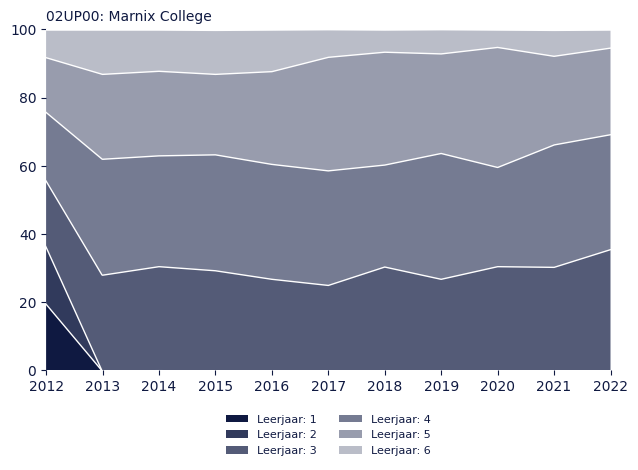

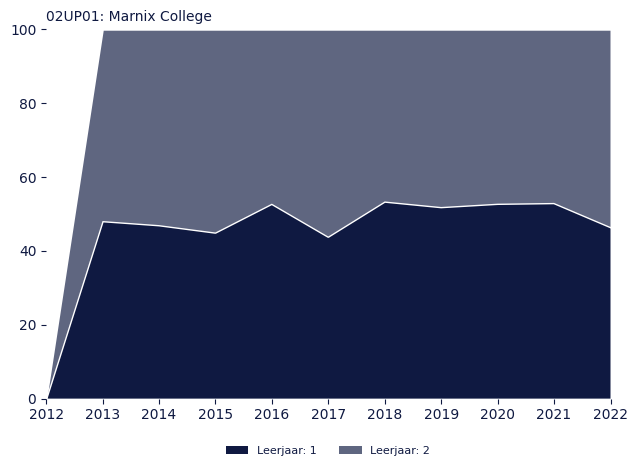

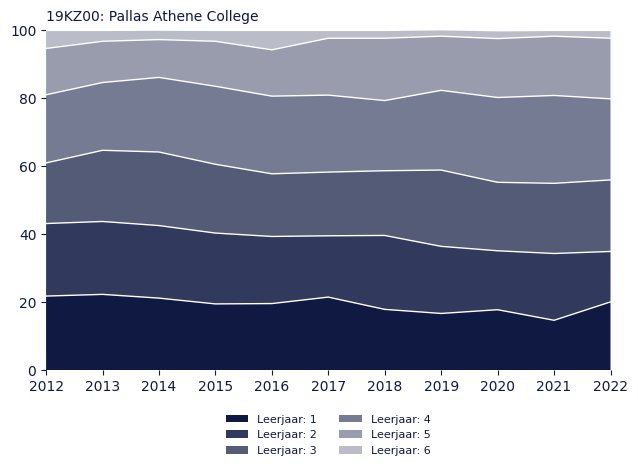

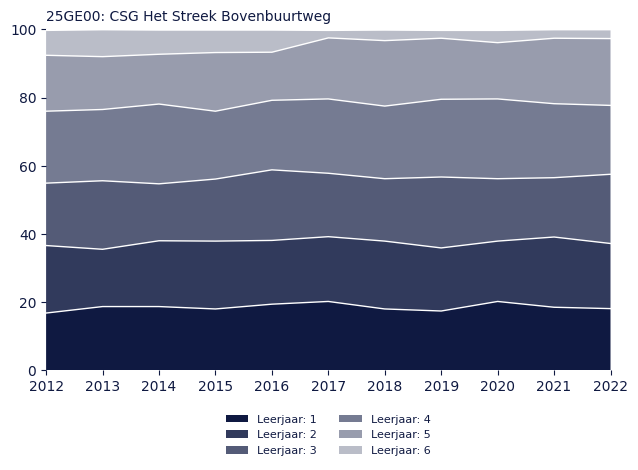

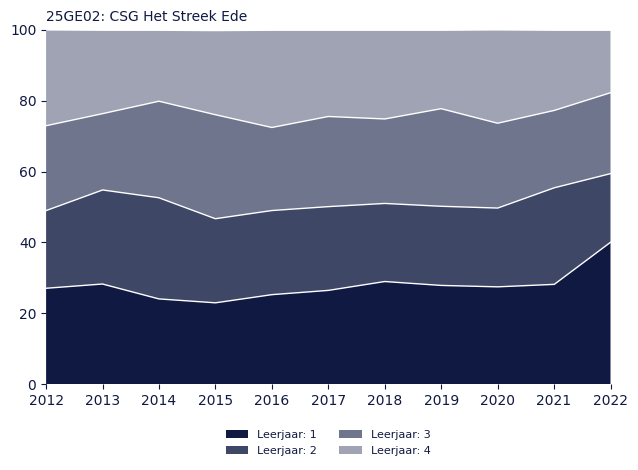

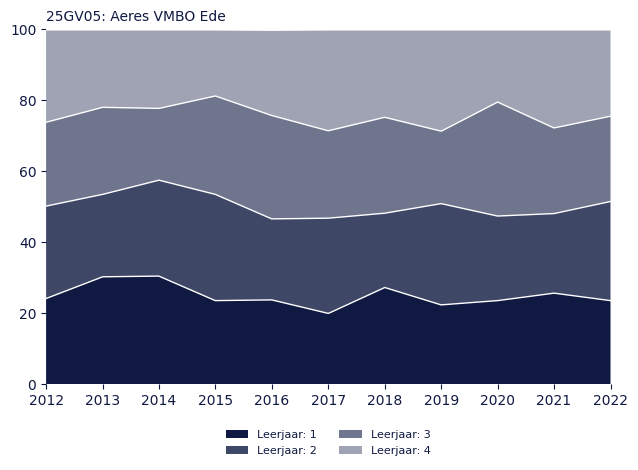

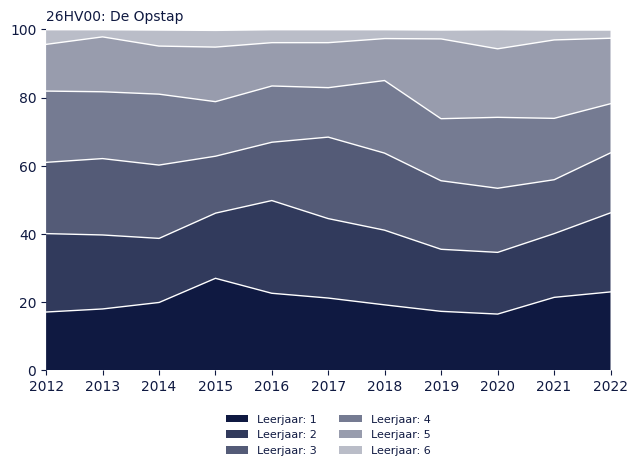

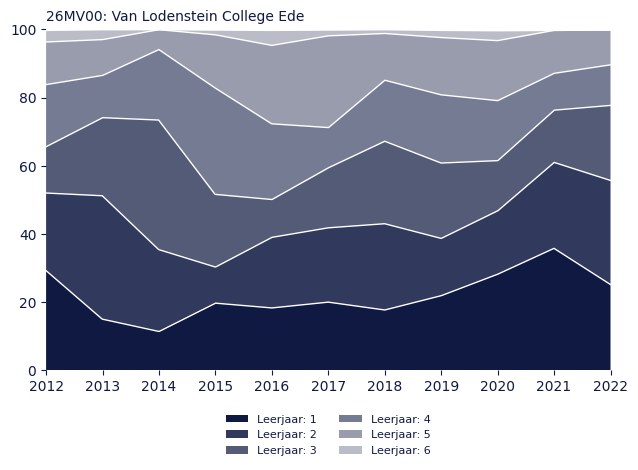

In [586]:
#@title
# placeholders variabelen
mod_array = np.array

var_to_axis_map_out = {}

var_to_axis_map_out_out = {}

perc = False

selected_split_vars_so = []

selected_split_vars_percentages = []

label_widget_perc = widgets.Label()

perc_agg_vars_widg = widgets.Label()

widget_frame = widgets.Label()

# widget: label
label_widget_split = widgets.Label(value = 'Selecteer variabelen om over te splitsen:',
                                   style = dict(font_weight='bold'),
                                   layout = widgets.Layout(width='400px', height='25px'))

# widget: select splitvariabele
split_var_options = ['Soort onderwijs', 'Elementcode', 'Afdeling',
                     'Sector (VMBO)', 'Leerjaar', 'VMBO-categorie']

split_vars_widg_so = widgets.SelectMultiple(options = split_var_options,
                                           layout = widgets.Layout(width='400px', height='100px'))

split_vars_widg_so.observe(set_split_vars_so, names = 'value')

# widget: knop om te tonen
show_button_so = widgets.Button(description = 'Toon data',
                                style = dict(font_weight='bold', font_size = 24),
                                layout = widgets.Layout(width='400px', height='50px'))

show_button_so.on_click(toon_data_so)

# widget: selecteer of percentages
perc_set_widget = widgets.Checkbox(description = 'Bereken percentages',
                                   indent = False)

perc_set_widget.observe(set_perc_bool, names = 'value')

#perc_set_widget.observe(maak_perc_widget, names = 'value')

perc_set_widget.observe(maak_widget_frame, names = 'value')


# widgets tonen
maak_widget_frame()

display('Nog geen data getoond', display_id = 2)

### **Verdeling binnen VMBO**

Dit overzicht laat de aantallen binnen het VMBO zien, specifiek ingezoomd op 3 onderwijssoorten binnen de VMBO-bovenbouw

In [587]:
#@title
def set_split_vars_vmbo(*args):

  global selected_split_vars_vmbo

  selected_split_vars_vmbo = split_vars_widg_vmbo.value

def set_vmbo_perc(*args):

  global vmbo_perc

  vmbo_perc = vmbo_perc_set_widget.value

def show_data_vmbo(*args):

  global out_results

  split_vars = list(selected_split_vars_vmbo)

  fixed_split_vars = ['BRIN (vestiging)']

  filter_var = 'Soort onderwijs'

  filter_vals = ['VMBO BL lj 3-4', 'VMBO GL lj 3-4', 'VMBO KL lj 3-4']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per onderwijssoort']).values()

  sub_filtered_array = filtered_array.copy()

  sub_filtered_array = array_filter(sub_filtered_array, var_to_axis_map, val_to_index_on_axis_map, filter_var, filter_vals)

  show_frame = array_naar_show_frame(sub_filtered_array, var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     split_vars,
                                     fixed_split_vars,
                                     vmbo_perc,
                                     [])

  display(show_frame, display_id = 2)

  out_results['Verdeling binnen VMBO'] = show_frame

In [588]:
#@title

selected_split_vars_vmbo = []

vmbo_perc = False


label_widget_vmbo = widgets.Label(value = 'Selecteer variabelen om over te splitsen:',
                                 style = dict(font_weight='bold'),
                                 layout = widgets.Layout(width='400px', height='25px'))

split_var_options_vmbo = ['Soort onderwijs', 'Sector (VMBO)', 'Leerjaar', 'VMBO-categorie']

split_vars_widg_vmbo = widgets.SelectMultiple(options = split_var_options_vmbo,
                                             layout = widgets.Layout(width='400px', height='60px'))
split_vars_widg_vmbo.observe(set_split_vars_vmbo, names = 'value')


vmbo_perc_set_widget = widgets.Checkbox(description = 'Bereken percentages',
      	                                indent = False)

vmbo_perc_set_widget.observe(set_vmbo_perc, names = 'value')

show_button_vmbo = widgets.Button(description = 'Toon data',
                                  style = dict(font_weight='bold', font_size = 24),
                                  layout = widgets.Layout(width='400px', height='50px'))

show_button_vmbo.on_click(show_data_vmbo)

full_widg = widgets.VBox(children = [label_widget_vmbo, split_vars_widg_vmbo,
                                     show_button_vmbo, vmbo_perc_set_widget])

display(full_widg, display_id = 1)

display('Nog geen data getoond', display_id = 2)

'Nog geen data getoond'

<DisplayHandle display_id=2>

### **Verdeling bovenbouw/onderbouw**

Dit overzicht laat zien welk percentage van de leerlingen per vestiging tot de bovenbouw behoort

In [589]:
# @title
def set_bb_perc(*args):

  global bb_perc

  bb_perc = bb_perc_set_widget.value

def show_data_bb(*args):

  global out_results

  split_vars = ['Bovenbouw']

  fixed_split_vars =  ['BRIN (vestiging)']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per onderwijssoort']).values()

  show_frame = array_naar_show_frame(filtered_array, var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     split_vars,
                                     fixed_split_vars,
                                     bb_perc,
                                     ['BRIN (vestiging)'])

  display(show_frame, display_id = 2)

  out_results['Verdeling bovenbouw'] = show_frame

In [590]:
#@title

bb_perc = False

show_button_bb = widgets.Button(description = 'Toon data',
                                  style = dict(font_weight='bold', font_size = 24),
                                  layout = widgets.Layout(width='400px', height='50px'))

show_button_bb.on_click(show_data_bb)


bb_perc_set_widget = widgets.Checkbox(description = 'Bereken percentages',
      	                                indent = False)

bb_perc_set_widget.observe(set_bb_perc, names = 'value')




full_widg = widgets.VBox(children = [show_button_bb, bb_perc_set_widget])

display(full_widg, display_id = 1)

display('Nog geen data getoond', display_id = 2)

'Nog geen data getoond'

<DisplayHandle display_id=2>

### **Instromers per instelling**
Dit overzicht laat zien wat het aantal instromers is per vestiging. Een instromer is gedefinieerd als een leerling die woont in een andere gemeente dan de vestigingsgemeente van de vestiging waar de leerling staat ingeschreven

In [591]:
# @title
def set_inst_perc(*args):

  global inst_perc

  inst_perc = instr_perc_set_widget.value

def show_data_instromers(*args):

  global out_results

  split_vars = ['Woonachtig binnen gemeente instelling']

  fixed_split_vars = ['BRIN (vestiging)']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per woonplaats']).values()

  sub_filtered_array = filtered_array.copy()

  show_frame = array_naar_show_frame(sub_filtered_array, var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     split_vars,
                                     fixed_split_vars,
                                     inst_perc,
                                     [])


  display(show_frame, display_id = 2)

  out_results['Verdeling binnen VMBO'] = show_frame

In [592]:
#@title
inst_perc = False

show_button_inst = widgets.Button(description = 'Toon data',
                                  style = dict(font_weight='bold', font_size = 24),
                                  layout = widgets.Layout(width='400px', height='50px'))

show_button_inst.on_click(show_data_instromers)


instr_perc_set_widget = widgets.Checkbox(description = 'Bereken percentages',
      	                              indent = False)

instr_perc_set_widget.observe(set_inst_perc, names = 'value')


full_widg = widgets.VBox(children = [show_button_inst, instr_perc_set_widget])

display(full_widg, display_id = 1)

display('Nog geen data getoond', display_id = 2)

'Nog geen data getoond'

<DisplayHandle display_id=2>

### **Herkomst instromers**

Dit overzicht laat zien wat de herkomstgemeente is van de (van buiten de vestigingsgemeente) instromende leerlingen.

De data is in te zien voor verschillende jaren. De 'default' is het meest recente bekende jaar. Eerdere jaren kunnen met behulp van de slider worden geselecteerd

In [593]:
# @title
def set_jaar(*args):

  global select_jaar

  select_jaar = slider_jaar_select.value

def show_data_inst_herk(*args):

  global out_results

  split_vars = ['Gemeentenummer (leerling)']

  fixed_split_vars = ['BRIN (vestiging)']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per woonplaats']).values()

  sub_filtered_array = filtered_array.copy()

  sub_filtered_array = array_filter(sub_filtered_array,
                                    var_to_axis_map,
                                    val_to_index_on_axis_map,
                                    'Woonachtig binnen gemeente instelling',
                                    [False])

  sub_filtered_array = array_filter(sub_filtered_array,
                                    var_to_axis_map,
                                    val_to_index_on_axis_map,
                                    'Jaar',
                                    [select_jaar])

  show_frame = array_naar_show_frame(sub_filtered_array, var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     split_vars,
                                     fixed_split_vars,
                                     False,
                                     [])

  show_frame.reset_index(inplace = True)
  # show_frame = codes_to_labels(show_frame,
  #                             ['BRIN (instelling)', 'BRIN (vestiging)'],
  #                             ['Instelling', 'Vestiging'])


  show_frame['Gemeentenummer (leerling)'] = show_frame['Gemeentenummer (leerling)']\
                                              .apply(lambda x: code_2_name_maps['Gemeentenummer (instelling)'][x] )

  show_frame.rename(columns = {'Gemeentenummer (leerling)' : 'Gemeentenaam (leerling)' },
                    inplace = True)

  show_frame = show_frame.round(2)

  show_frame = show_frame\
    .sort_values(by = select_jaar, ascending = False)\
    .sort_values(by = 'Instelling')\
    .sort_values(by = 'Vestiging')

  show_frame.set_index(['Instelling', 'Vestiging', 'Gemeentenaam (leerling)'], inplace = True)

  show_frame = show_frame[[select_jaar]]

  display(show_frame.head(20), display_id = 2)

  out_results['Herkomst instromers'] = show_frame

In [594]:
#@title
# slider_jaar_select = widgets.IntSlider(min = 2012,#np.min(out_frame_woonp['Jaar']),
#                                        max = 2022, #np.max(out_frame_woonp['Jaar']),
#                                        step = 1,
#                                        value = 2022)

select_jaar =  np.max(data['Aantallen per onderwijssoort']['Jaar'])

#slider_jaar_select.observe(set_jaar, names = 'value' )

show_button_inst_herk = widgets.Button(description = 'Toon data',
                                       style = dict(font_weight='bold', font_size = 24),
                                       layout = widgets.Layout(width='400px', height='50px'))

show_button_inst_herk.on_click(show_data_inst_herk)

#full_widg = widgets.VBox(children = [slider_jaar_select, show_button_inst_herk])

full_widg = widgets.VBox(children = [show_button_inst_herk])

display(full_widg, display_id = 1)

display('Nog geen data getoond', display_id = 2)

'Nog geen data getoond'

<DisplayHandle display_id=2>

### **Voedingsgebieden op kaart**

Gebruikers kunnen de voedingsgebieden van een geselecteerde vestiging op de kaart visualiseren. In ontwikkeling

In [616]:
# @title
def select_brin6(*args):

  global selected_brin6

  if len(select_brin6_kaart_widg.value) > 0:

    selected_brin6 = [reverse_brin6_to_name_map[full_name] for full_name in select_brin6_kaart_widg.value]

  else:

    selected_brin6 = brin6_select_widget.options



def update_select_widg(*args):

  global select_brin6_kaart_widg

  select_brin6_kaart_widg.options = [code_2_name_maps['BRIN (vestiging)'][brin6[1]] for brin6 in brin6_select_widget.options]



def toon_kaart(fig, gdf_merge, show_frame, centroids):

  ax = fig.gca()

  ax.cla()

  gdf_merge.plot(edgecolor = primary_colors[2],
                 facecolor =  primary_colors[0],
                 linewidth = 0.4,
                 alpha = gdf_merge['Alpha'],
                 ax = ax, legend = True)

  ax.axis('off')

  #ax.legend()

  for gemcode in set(show_frame.index.values).intersection(gdf_merge.index.values):

      x, y = centroids.loc[gemcode, ['x', 'y']]

      if box_gemnamen.value:

        ax.text(s = code_2_name_maps['Gemeentenummer (instelling)'].get(gemcode),
                x = x + 4000, y = y,
                fontsize = 12,
                zorder = 3)

  display(fig, display_id = 1)

  global out_results

  out_results['Voedingsgebied op kaart'] = fig

In [617]:
# @title
def maak_kaart_inst_herk(*args):

  selection_cols = ['BRIN (vestiging)']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Aantallen per woonplaats']).values()

  sub_filtered_array = filtered_array.copy()

  sub_filtered_array = array_filter(sub_filtered_array,
                                    var_to_axis_map,
                                    val_to_index_on_axis_map,
                                    'BRIN (vestiging)',
                                    selected_brin6
                                    )

  sub_filtered_array = array_filter(sub_filtered_array,
                                    var_to_axis_map,
                                    val_to_index_on_axis_map,
                                    'Jaar',
                                    [select_jaar]
                                    )

  show_frame = array_naar_show_frame(sub_filtered_array,
                                     var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     ['Gemeentenummer (leerling)'],
                                     selection_cols,
                                     False,
                                     [])

  show_frame.reset_index(inplace = True)

  # aggregreren over vestigingselectie
  show_frame['Aantal'] = show_frame[select_jaar]

  show_frame.drop(val_to_index_on_axis_map['Jaar'].keys(), axis = 1, inplace  = True)

  show_frame_grouper = [show_frame['Gemeentenummer (leerling)'] ,show_frame['Instelling']]

  show_frame = show_frame[['Aantal']].groupby(show_frame_grouper).sum()

  show_frame.reset_index(inplace = True)

  show_frame.set_index('Gemeentenummer (leerling)', inplace = True)



  gdf_merge = pd.merge(gdf, show_frame, how = 'left', left_index = True, right_index = True)

  gdf_merge['Aantal'].fillna(0, inplace = True)

  gdf_merge['Alpha'] = gdf_merge['Aantal'].apply(lambda x: (1 - 0.8) + (x / (max(gdf_merge['Aantal']) * (1 / 0.8))) if x > 0 else 0.1)

  centroids = gdf_merge[['x', 'y']].groupby(level = 0).mean()


  toon_kaart(fig, gdf_merge, show_frame, centroids)

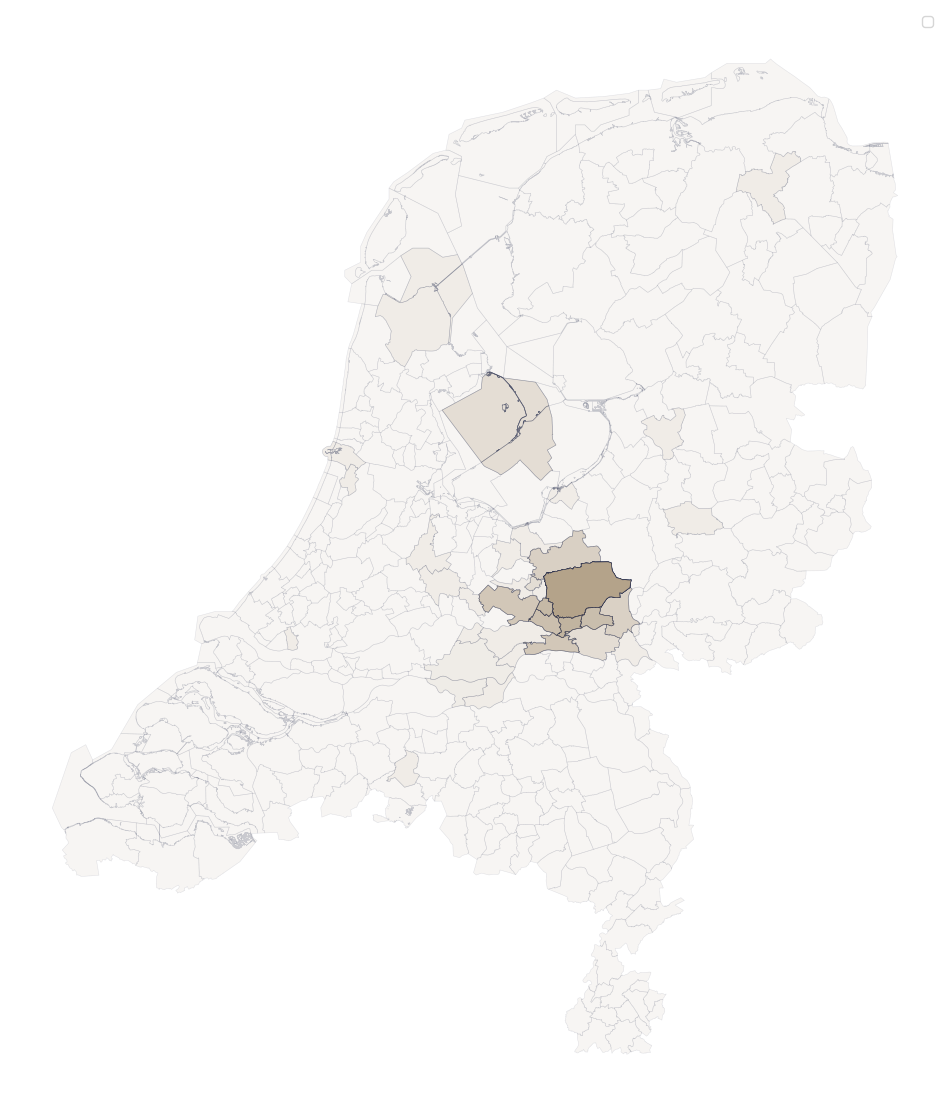

<DisplayHandle display_id=1>

<Figure size 1200x1800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [615]:
# @title
reverse_brin6_to_name_map = {value: key for key, value in code_2_name_maps['BRIN (vestiging)'].items()}

select_brin6_kaart_widg = widgets.SelectMultiple(options = [code_2_name_maps['BRIN (vestiging)'][brin6[1]] for brin6 in brin6_select_widget.options],
                                                 description = 'Kies vestiging',
                                                 style = {'description_width': '82px'},
                                                 layout = widgets.Layout(width = '600px'))

selected_brin6 = [reverse_brin6_to_name_map[full_name] for full_name in select_brin6_kaart_widg.value]

box_gemnamen = widgets.Checkbox(description = 'toon gemeentenamen', indent = False)

maak_kaart_button = widgets.Button(description = 'Maak kaart',
                                   style = dict(font_weight='bold', font_size = 24),
                                   layout = widgets.Layout(width='600px', height='50px'))

update_brin6_list_but = widgets.Button(description = 'Update selectie vestigingen',
                                       style = dict(font_weight='bold', font_size = 24),
                                       layout = widgets.Layout(width='600px', height='30px'))

select_brin6_kaart_widg.observe(select_brin6, names = 'value' )

maak_kaart_button.on_click(maak_kaart_inst_herk)

update_brin6_list_but.on_click(update_select_widg)

full_widgets = widgets.VBox(children  = [select_brin6_kaart_widg,
                                         update_brin6_list_but,
                                         maak_kaart_button,
                                         box_gemnamen])


fig = plt.figure(figsize = (12, 18))

display(full_widgets, display_id = 0)

display(fig, display_id = 1)

### **Uitstromers**

Dit overzicht laat zien waar (per woongemeente) uitstromende leerlingen naar school gaan.

In [598]:
#@title
def show_data_uitst(*args):

  selectie_uitst = data['Aantallen per woonplaats']

  selectie_gem_instelling = arrays_dict['Aantallen per woonplaats']['idx_locaties_per_val_per_cat']['Gemeentenummer (instelling)'].keys()

  select_bool = selectie_uitst['Woonachtig binnen gemeente instelling'].apply(lambda x: not x)

  selectie_uitst = selectie_uitst.loc[select_bool]

  show_select_grouper_vars = ['Gemeentenummer (leerling)', 'Gemeentenummer (instelling)', 'Jaar']

  grouper_obj = [selectie_uitst[col] for col in show_select_grouper_vars]

  show_frame = selectie_uitst[['Aantal']].groupby(grouper_obj).sum()

  show_frame = show_frame.unstack(level = -1, fill_value = 0)

  show_frame.reset_index(inplace = True)

  show_frame_select_bool = show_frame['Gemeentenummer (leerling)']\
    .apply(lambda x: x in selectie_gem_instelling)

  show_frame = show_frame.loc[show_frame_select_bool]

  show_frame['Gemeentenummer (leerling)'] = show_frame['Gemeentenummer (leerling)']\
                                                .apply(lambda x: code_2_name_maps['Gemeentenummer (instelling)'][x] )

  show_frame['Gemeentenummer (instelling)'] = show_frame['Gemeentenummer (instelling)']\
                                                .apply(lambda x: code_2_name_maps['Gemeentenummer (instelling)'][x] )

  sorter = np.argsort(show_frame.iloc[:, -1])[::-1]

  show_frame = show_frame.iloc[sorter]

  show_frame.rename(columns = {'Gemeentenummer (leerling)' : 'Woongemeente uitstromers',
                               'Gemeentenummer (instelling)' : 'Schoolgemeente uitstromers'},
                    inplace = True)

  show_frame = show_frame.round(2)

  show_frame.set_index(['Woongemeente uitstromers', 'Schoolgemeente uitstromers'], inplace = True)

  display(show_frame, display_id = 2)

  global out_results

  out_results['Uitstromers'] = show_frame

In [599]:
#@title
show_button_uitst = widgets.Button(description = 'Toon data',
                                   style = dict(font_weight='bold', font_size = 24),
                                   layout = widgets.Layout(width='400px', height='50px'))

show_button_uitst.on_click(show_data_uitst)

display(show_button_uitst, display_id = 1)

Button(description='Toon data', layout=Layout(height='50px', width='400px'), style=ButtonStyle(font_weight='bo…

<DisplayHandle display_id=1>

### **Prognose**
Dit overzicht laat de DUO-prognose zien per vestiging.
*  Het eerste jaar van de prognosereeks is de laatst bekende feitelijke reeks
*  De indeling van de prognose is een andere indeling dan wordt gebruikt in de DUO-prognose


In [600]:
# @title
def set_add_splits(*args):

  split_ow_soort_bool = select_split.value

  global add_split_vars

  if split_ow_soort_bool:
    add_split_vars = ['Onderwijssoort']

  else:
    add_split_vars = []


def show_data_progs(*args):

  global out_results

  fixed_split_vars = ['BRIN (vestiging)']

  filtered_array, var_to_axis_map, val_to_index_on_axis_map = dict(arrays_dict['Prognose']).values()

  sub_filtered_array = filtered_array.copy()

  show_frame = array_naar_show_frame(sub_filtered_array, var_to_axis_map,
                                     val_to_index_on_axis_map,
                                     ['Onderwijssoort'],
                                     fixed_split_vars,
                                     False,
                                     [])

  # show_frame = codes_to_labels(show_frame,
  #                             ['BRIN (instelling)', 'BRIN (vestiging)'],
  #                             ['Instelling', 'Vestiging'])

  # show_frame.set_index(['Instelling', 'Vestiging'] + add_split_vars, inplace = True)

  display(show_frame, display_id = 2)

  out_results['Prognose'] = show_frame

In [601]:
#@title
add_split_vars = []

show_button_progs = widgets.Button(description = 'Toon data',
                                   style = dict(font_weight='bold', font_size = 24),
                                   layout = widgets.Layout(width='400px', height='50px'))

select_split = widgets.Checkbox(description = "Splits data over 'Onderwijssoort'",
                                indent = False)

set_add_splits()

show_button_progs.on_click(show_data_progs)

select_split.observe(set_add_splits, names = 'value' )

display(show_button_progs, display_id = 1)

display(select_split, display_id = 2)

Button(description='Toon data', layout=Layout(height='50px', width='400px'), style=ButtonStyle(font_weight='bo…

Checkbox(value=False, description="Splits data over 'Onderwijssoort'", indent=False)

<DisplayHandle display_id=2>

### **Export naar spreadsheet maken**

Hier kan de gebruiker een spreadsheet in Excel-format maken waarin alle bovenstaande overzichten geëxporteerd zijn. Deze wordt automatisch opgeslagen in de Google Drive van de gebruiker in de root directory

In [602]:
#@title
def set_outfile_name(*args):

  global outfile_name

  outfile_name = outfile_name_widget.value


def save_to_excel(*args):

  outfile_generator = pd.ExcelWriter(os.path.join(out_results_save_map, f'{outfile_name}.xlsx'))

  book = outfile_generator.book

  for sheet_name in out_results.keys():

    sheet_name_out = sheet_name.replace(' ','_')

    content = out_results[sheet_name]

    if isinstance(content, pd.DataFrame):

      content.to_excel(outfile_generator, sheet_name = sheet_name_out)

    elif isinstance(content, dict):

      for key, sub_content in content.items():

        if isinstance(sub_content, pd.DataFrame):

          sub_content.to_excel(outfile_generator, sheet_name = sheet_name_out)

        elif isinstance(sub_content, list):

          for fig_i, fig in enumerate(sub_content):

            sheet = book[sheet_name_out]

            image_data = io.BytesIO()

            fig.savefig(image_data, format='png')

            out_image = Image(image_data)

            sheet.add_image(out_image, f'O{(fig_i * 3) + 1}')

    else:

      book.create_sheet(sheet_name_out)

      sheet = book[sheet_name_out]

      image_data = io.BytesIO()

      content.savefig(image_data, format='png')

      out_image = Image(image_data)

      sheet.add_image(out_image, 'A1')


  outfile_generator.close()

In [603]:
#@title

outfile_name = 'geen naam'

outfile_name_widget = widgets.Text(value = 'Voer bestandsnaam in')

xlsx_save_button = widgets.Button(description = 'Exporteer naar spreadsheet',
                                   style = dict(font_weight='bold', font_size = 24),
                                   layout = widgets.Layout(width='400px', height='50px'))

outfile_name_widget.observe(set_outfile_name, names = 'value')

xlsx_save_button.on_click(save_to_excel)

display(outfile_name_widget, xlsx_save_button)

Text(value='Voer bestandsnaam in')

Button(description='Exporteer naar spreadsheet', layout=Layout(height='50px', width='400px'), style=ButtonStyl…

/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


boom
